In [1]:
!pip install shap

In [2]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import shap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Prediction

In [3]:
input_train = pd.read_csv("Training_Validation_Test_Datasets/task2_input_train.csv", index_col=0)
input_validate = pd.read_csv("Training_Validation_Test_Datasets/task2_input_validate.csv", index_col=0)
input_test = pd.read_csv("Training_Validation_Test_Datasets/task2_input_test.csv", index_col=0)

output_train = pd.read_csv("Training_Validation_Test_Datasets/task2_output_train.csv")["phq_sum"]
output_validate = pd.read_csv("Training_Validation_Test_Datasets/task2_output_validate.csv")["phq_sum"]
output_test = pd.read_csv("Training_Validation_Test_Datasets/task2_output_test.csv")["phq_sum"]

In [4]:
lrs = [0.01, 0.05, 0.1, 0.2] # learning rate
ns = [50, 100, 250, 500] # number of estimators
depths = [4,6,8,12] # max depth
min_samples = [100,250,500,1000,1500,2000] # min sample split

In [5]:
results = []

for lr in lrs:
        for n in ns:
            for depth in depths:
                for min_sample in min_samples:
                    params = {
                        "n_estimators": n,
                        "max_depth": depth,
                        "min_samples_split": min_sample,
                        "learning_rate": lr,
                        "loss": "squared_error",
                        "random_state": 42
                    }

                    reg = ensemble.GradientBoostingRegressor(**params)
                    reg.fit(input_train, output_train)
                    
                    y_pred = reg.predict(input_validate)
                    mse = round(mean_squared_error(output_validate, y_pred), 4)
                    rmse = round(mse ** (1/2), 4)
                    
                    results.append({
                        "learning_rate": lr,
                        "n_estimators": n,
                        "max_depth": depth,
                        "min_samples_split": min_sample,
                        "MSE": mse,
                        "RMSE": rmse
                    })

In [6]:
results_df = pd.DataFrame(results)

best_row = results_df.loc[results_df["RMSE"].idxmin()]
best_params = best_row[["learning_rate", "n_estimators", "max_depth", "min_samples_split"]].to_dict()
best_rmse = best_row["RMSE"]

print("\nBest Hyperparameters:")
print(best_params)
print("Best Validation RMSE:", best_rmse)


Best Hyperparameters:
{'learning_rate': 0.1, 'n_estimators': 50.0, 'max_depth': 4.0, 'min_samples_split': 500.0}
Best Validation RMSE: 3.9012


### Feature by group

In [7]:
datasets = ["Grouping_Datasets/Female_Older.csv", 
            "Grouping_Datasets/Female_Younger.csv", 
            "Grouping_Datasets/Male_Older.csv", 
            "Grouping_Datasets/Male_Younger.csv"]

param_grid = {
    "learning_rate": 0.1,
    "n_estimators": 50,
    "max_depth": 4,
    "min_samples_split": 500}

Processing Grouping_Datasets/Female_Older.csv...


/tmp/ipykernel_392/379778620.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_results = pd.concat([all_results, pd.DataFrame({


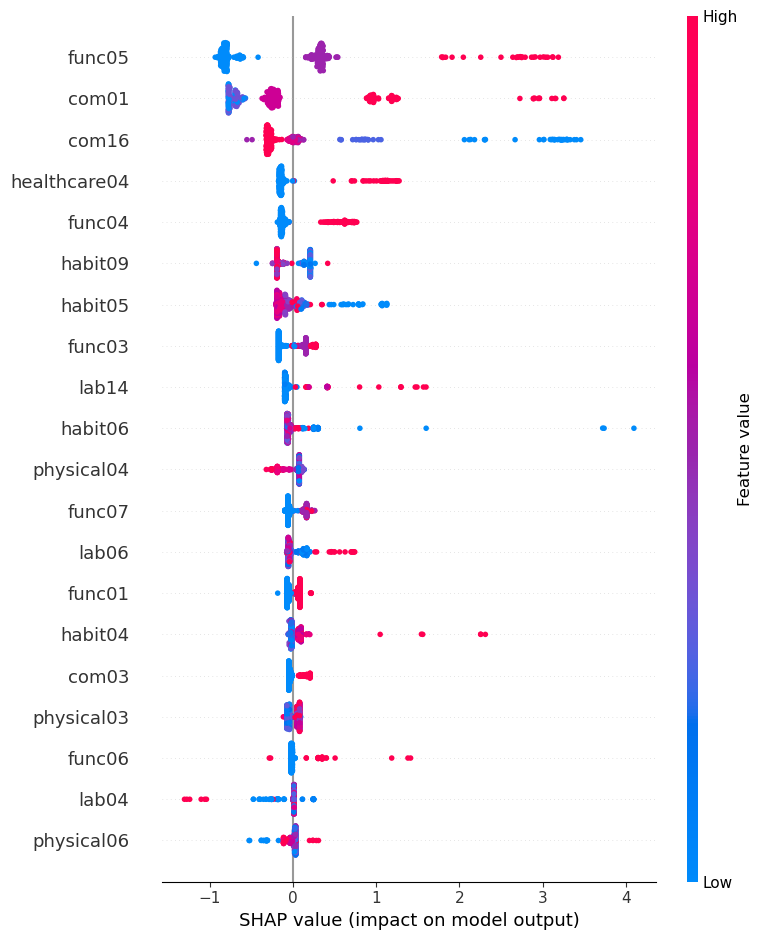

Processing Grouping_Datasets/Female_Younger.csv...


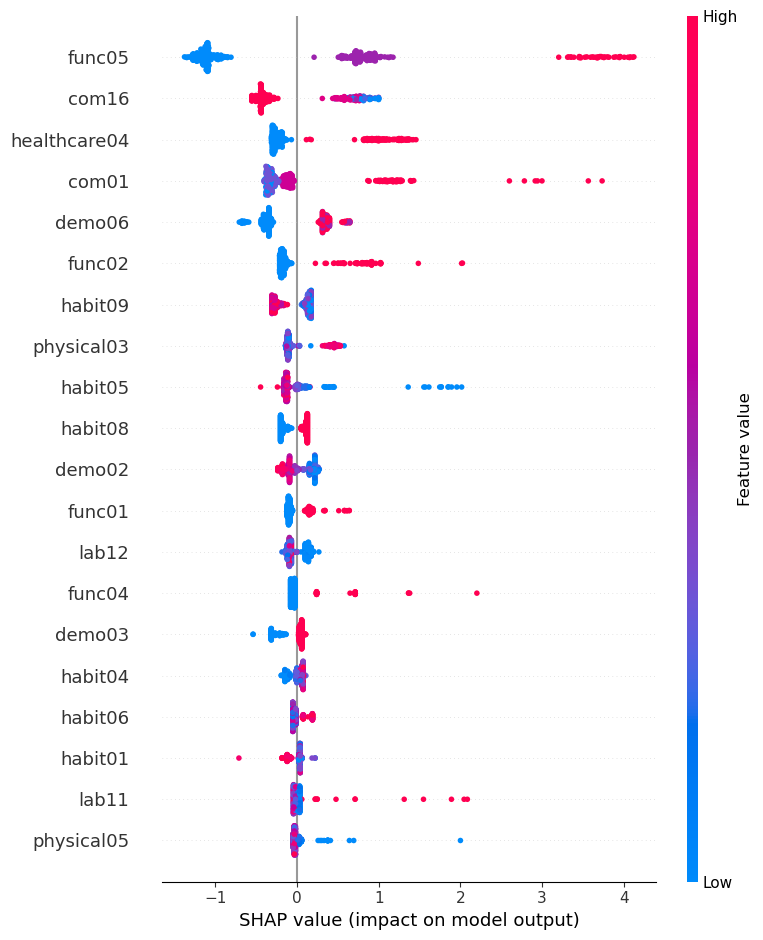

Processing Grouping_Datasets/Male_Older.csv...


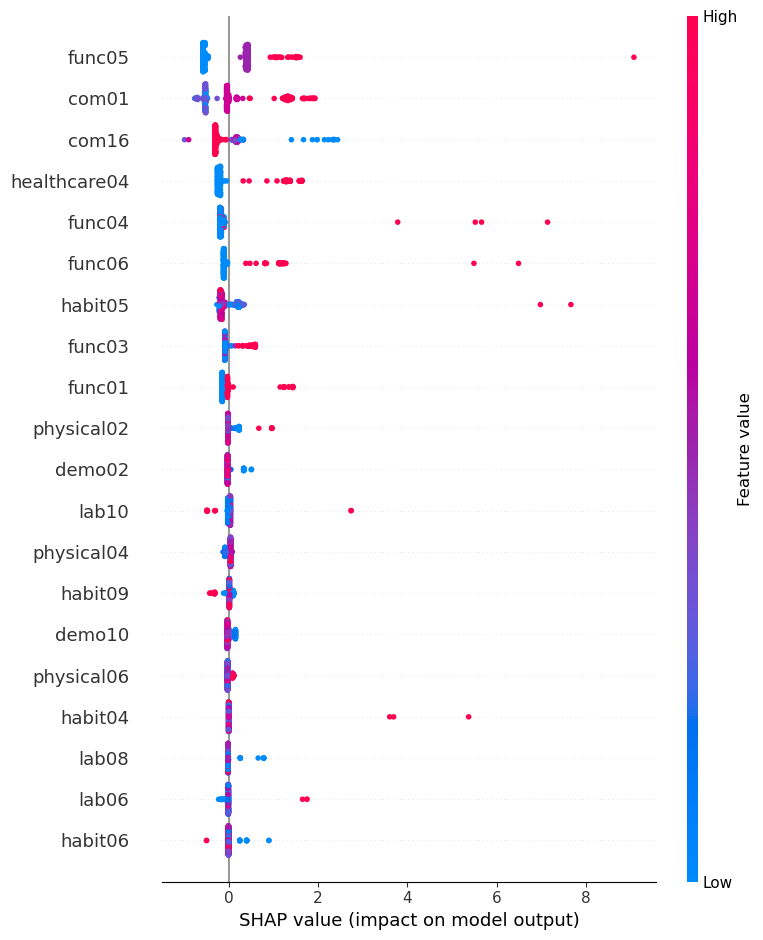

Processing Grouping_Datasets/Male_Younger.csv...


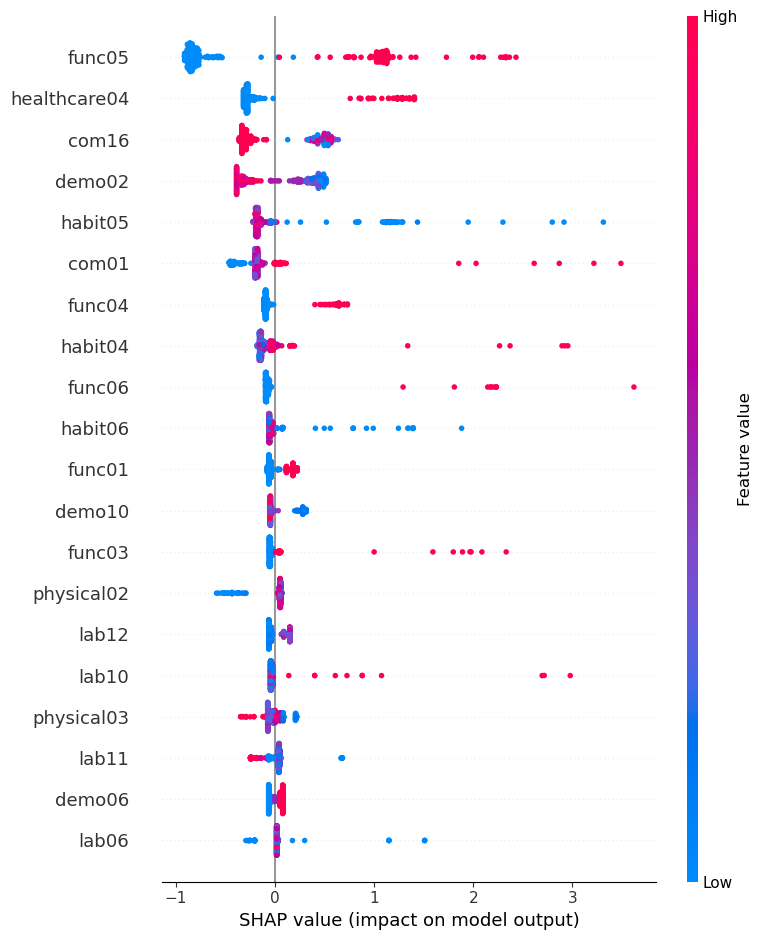


Evaluation Results:
                                Dataset        MSE      RMSE
0    Grouping_Datasets/Female_Older.csv  12.548515  3.542388
1  Grouping_Datasets/Female_Younger.csv  16.405069  4.050317
2      Grouping_Datasets/Male_Older.csv  10.929721  3.306013
3    Grouping_Datasets/Male_Younger.csv  18.756923  4.330926


In [8]:
all_results = pd.DataFrame(columns=["Dataset", "MSE", "RMSE"])

for dataset in datasets:
    print(f"Processing {dataset}...")
    
    data = pd.read_csv(dataset, index_col=0)
    
    X = data.drop(columns=["phq_sum"])
    y = data["phq_sum"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                        random_state=42)
    
    gb_model = GradientBoostingRegressor(
        learning_rate=param_grid["learning_rate"],
        n_estimators=param_grid["n_estimators"],
        max_depth=param_grid["max_depth"],
        min_samples_split=param_grid["min_samples_split"],
        random_state=42)
    
    gb_model.fit(X_train, y_train)
    
    y_test_pred = gb_model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = mse_test ** (1/2) 
    
    
    all_results = pd.concat([all_results, pd.DataFrame({
        "Dataset": [dataset],
        "MSE": [mse_test],
        "RMSE": [rmse_test]})], ignore_index=True)
    
    # SHAP Analysis
    explainer = shap.Explainer(gb_model, X_train)
    shap_values = explainer(X_test)

    # Print SHAP summary plot
    shap.summary_plot(shap_values, X_test)
    
# Print evaluation results
print("\nEvaluation Results:")
print(all_results)